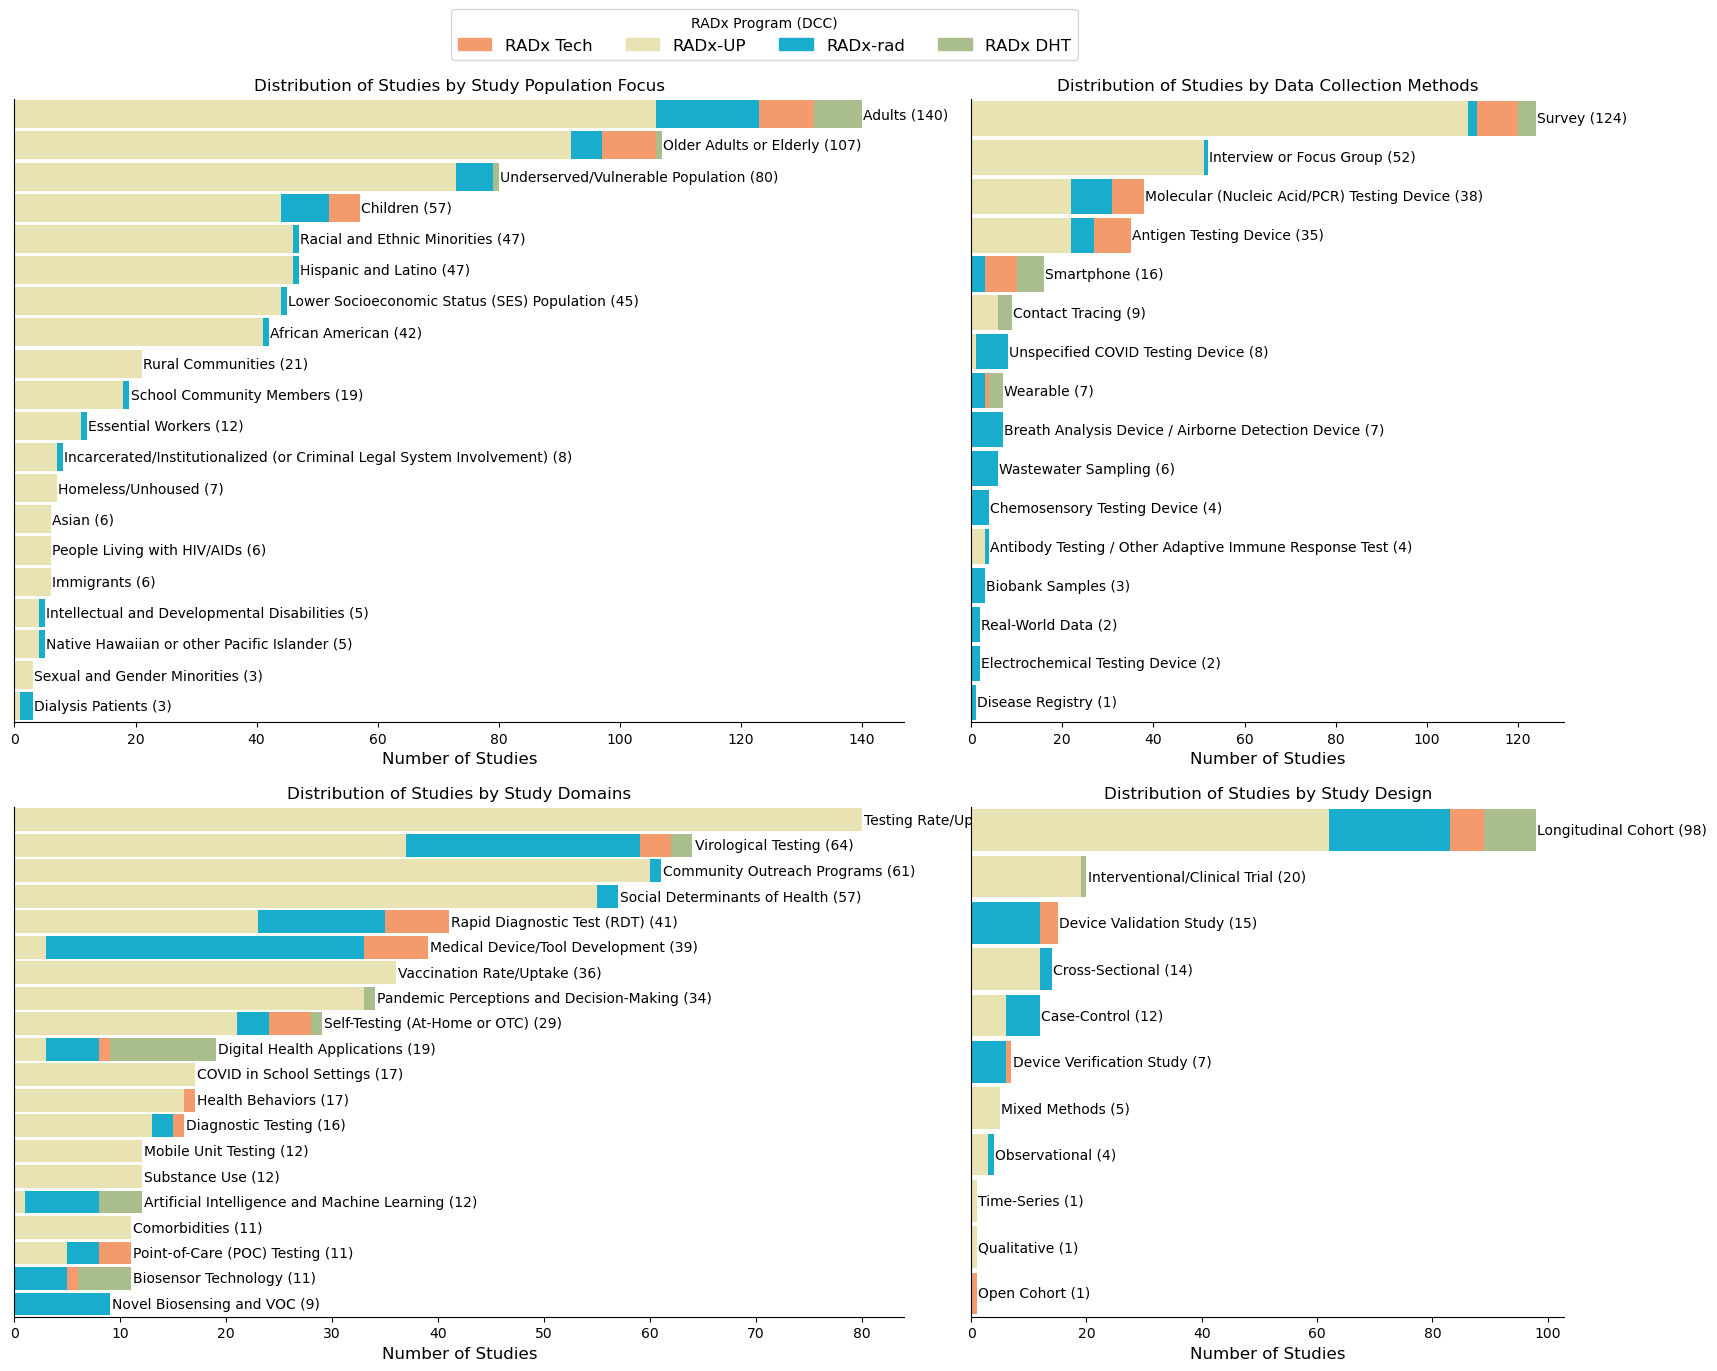

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
file_path = "StudyExplorerResults.csv"  # Replace with your file path
data = pd.read_csv(file_path, encoding="latin1")

# Process the data
data["Study Population Focus"] = data["Study Population Focus"].str.split("; ")
data["Study Domain"] = data["Study Domain"].str.split("; ")
data["Data Collection Method"] = data["Data Collection Method"].str.split("; ")

# Explode columns to have one value per row for analysis
exploded_population_focus = data.explode("Study Population Focus")
exploded_study_domain = data.explode("Study Domain")
exploded_data_collection = data.explode("Data Collection Method")

# Count occurrences for each category in each field
top_population_focus = exploded_population_focus["Study Population Focus"].value_counts().head(20)
top_study_domain = exploded_study_domain["Study Domain"].value_counts().head(20)
top_data_collection = exploded_data_collection["Data Collection Method"].value_counts().head(20)

# Define colors for RADx programs
radx_colors = {
    "RADx Tech": "#F39B6D",
    "RADx-UP": "#E9E3B4",
    "RADx-rad": "#18accd",
    "RADx DHT": "#AABD8C",
}

# Prepare dataframes for plotting
def prepare_stacked_data(column_name, top_categories):
    exploded = data.explode(column_name)
    filtered = exploded[exploded[column_name].isin(top_categories.index)]
    grouped = filtered.groupby([column_name, "RADx Data Program"]).size().unstack(fill_value=0)
    # Ensure all RADx Programs are represented
    for program in radx_colors.keys():
        if program not in grouped.columns:
            grouped[program] = 0
    return grouped

stacked_population_focus = prepare_stacked_data("Study Population Focus", top_population_focus)
stacked_study_domain = prepare_stacked_data("Study Domain", top_study_domain)
stacked_data_collection = prepare_stacked_data("Data Collection Method", top_data_collection)
stacked_study_design = data.groupby(["Study Design", "RADx Data Program"]).size().unstack(fill_value=0)
# Ensure all RADx Programs are represented in stacked_study_design
for program in radx_colors.keys():
    if program not in stacked_study_design.columns:
        stacked_study_design[program] = 0

# Function to sort data so that the smallest bar segments are at the top
def sort_stacked_data_internally(data):
    # Sort columns (RADx Programs) by overall sum descending
    data = data[data.sum().sort_values(ascending=False).index]
    # Sort rows (categories) by total sum ascending
    data = data.loc[data.sum(axis=1).sort_values(ascending=True).index]
    # For each row, sort the values in ascending order
    sorted_data = pd.DataFrame(index=data.index, columns=data.columns)
    for idx in data.index:
        row = data.loc[idx]
        sorted_row = row.sort_values(ascending=True)
        sorted_data.loc[idx] = sorted_row
    return sorted_data

# Sort the data
sorted_population_focus = sort_stacked_data_internally(stacked_population_focus)
sorted_study_domain = sort_stacked_data_internally(stacked_study_domain)
sorted_data_collection = sort_stacked_data_internally(stacked_data_collection)
sorted_study_design = sort_stacked_data_internally(stacked_study_design)

# Function to plot horizontal stacked bars with category labels and magnitudes
def plot_stacked_bars_with_labels_aligned_at_xaxis(
    data_list, titles, ylabel, colors=None,
    output_file="horizontal-bars.png"
):
    fig, axes = plt.subplots(
        2, 2, figsize=(20, 14),
        gridspec_kw={
            'height_ratios': [1.1, 0.9],  # Top row taller than bottom row
            'width_ratios': [1.2, 0.8]   # Left column wider than right column
        },
        constrained_layout=False
    )
    axes = axes.flatten()

    # Adjust subplot parameters to reduce space between columns and rows
    plt.subplots_adjust(wspace=0.09, hspace=0.15, top=0.98)

    for i, data in enumerate(data_list):
        ax = axes[i]

        # Set the index name to 'Category'
        data.index.name = 'Category'

        # Convert data to long format
        data_long = data.reset_index().melt(id_vars='Category', var_name='RADx Program', value_name='Value')

        # Sort categories by total value ascending
        category_totals = data_long.groupby('Category')['Value'].sum().sort_values(ascending=True)
        data_long['Category'] = pd.Categorical(data_long['Category'], categories=category_totals.index, ordered=True)

        # Get unique categories and positions
        categories = data_long['Category'].cat.categories
        category_positions = np.arange(len(categories))

        # Initialize bottoms for stacking
        bottoms = np.zeros(len(categories))

        bar_width = 0.9  # Adjust bar width as needed

        # Plot bars for each category with internal sorting
        for idx, category in enumerate(categories):
            df_cat = data_long[data_long['Category'] == category]
            for _, row in df_cat.iterrows():
                program = row['RADx Program']
                value = row['Value']
                if value > 0:
                    # Plot the horizontal bar
                    ax.barh(idx, value, left=bottoms[idx],
                            color=colors.get(program, None), height=bar_width, align='center')

                    # Stack the bar
                    bottoms[idx] += value

        # Add category names and magnitudes as labels on the bars
        for idx, category in enumerate(categories):
            total_value = category_totals[category]  # Get total value for the category
            ax.text(
                bottoms[idx] + 0.2,  # X-coordinate (just outside the last bar segment)
                idx,                # Y-coordinate (bar position)
                f"{category} ({int(total_value)})",  # Category name and its magnitude
                ha='left', va='center', fontsize=10, color='black'
            )

        # Remove y-axis ticks and labels
        ax.set_yticks([])

        # Remove the top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Set labels and title
        ax.set_xlabel(ylabel, fontsize=12)
        ax.set_title(titles[i], fontsize=12)

        # Reduce offset from x-axis
        ax.set_ylim([-0.5, len(categories) - 0.5])  # Adjust y-limits to reduce offset

    # Add a single legend for all subplots
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[prog]) for prog in colors]
    labels = list(colors.keys())
    # Position the legend at the top center, outside the plotting area
    fig.legend(handles, labels, title="RADx Program (DCC)", loc='upper center',
               ncol=4, fontsize=12, bbox_to_anchor=(0.5, 1.05))

    # Save the figure to a file
    plt.savefig(output_file, format="png", dpi=300, bbox_inches='tight')
    plt.show()

# Data and titles for the grid
data_list = [
    sorted_population_focus,
    sorted_data_collection,
    sorted_study_domain,
    sorted_study_design
]

titles = [
    "Distribution of Studies by Study Population Focus",
    "Distribution of Studies by Data Collection Methods",
    "Distribution of Studies by Study Domains",
    "Distribution of Studies by Study Design"
]

# Plot all charts with labels aligned at the x-axis and save to a file
plot_stacked_bars_with_labels_aligned_at_xaxis(
    data_list,
    titles,
    ylabel="Number of Studies",
    colors=radx_colors,
    output_file="stacked_bars_labels_horizontal.png"
)
